<a href="https://colab.research.google.com/github/RAvila-bioeng/M.R.AI/blob/main/alzheimer's_VGG16_Sin_truncar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install kaggle

In [13]:

from google.colab import drive
drive.mount('/content/gdrive')

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle_API"

# Descargar dataset
!kaggle datasets download -d ninadaithal/imagesoasis

# Descomprimir
!unzip -q imagesoasis.zip

import os
print("Contenido del directorio actual:", os.listdir("."))
print("Contenido de 'Data' si existe:", os.listdir("Data") if os.path.exists("Data") else "No existe 'Data'")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Dataset URL: https://www.kaggle.com/datasets/ninadaithal/imagesoasis
License(s): apache-2.0
imagesoasis.zip: Skipping, found more recently modified local copy (use --force to force download)
replace Data/Mild Dementia/OAS1_0028_MR1_mpr-1_100.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Data/Mild Dementia/OAS1_0028_MR1_mpr-1_101.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Contenido del directorio actual: ['.config', 'Data_subset', 'Data_split_binary', 'Data_split_3cls', 'Data', 'imagesoasis.zip', 'best_vgg16_binary.h5', 'gdrive', 'sample_data']
Contenido de 'Data' si existe: ['Non Demented', 'Very mild Dementia', 'Moderate Dementia', 'Mild Dementia']


In [14]:
import os
import shutil
import random
from collections import defaultdict

original_dir = "./Data"
assert os.path.exists(original_dir), "No existe ./Data. Revisa la celda 1."

subset_dir = "./Data_subset"

# Empezar *limpio*
if os.path.exists(subset_dir):
    shutil.rmtree(subset_dir)
os.makedirs(subset_dir, exist_ok=True)

valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
N_PATIENTS_NON_DEMENTED = 120  # nº máximo de pacientes sanos

classes = [d for d in os.listdir(original_dir)
           if os.path.isdir(os.path.join(original_dir, d))]
print("Clases encontradas en Data:", classes)

for cls in classes:
    src_cls_dir = os.path.join(original_dir, cls)
    dst_cls_dir = os.path.join(subset_dir, cls)
    os.makedirs(dst_cls_dir, exist_ok=True)

    print(f"\nProcesando clase: {cls}")

    if "non" not in cls.lower():   # todas menos Non Demented
        imgs = [f for f in os.listdir(src_cls_dir)
                if f.lower().endswith(valid_exts)]
        print(f"  Copiando TODAS las imágenes ({len(imgs)})...")
        for fname in imgs:
            shutil.copy2(os.path.join(src_cls_dir, fname),
                         os.path.join(dst_cls_dir, fname))

    else:
        # Non Demented: reducir por nº de pacientes
        imgs = [f for f in os.listdir(src_cls_dir)
                if f.lower().endswith(valid_exts)]
        print(f"  Imágenes totales en {cls}: {len(imgs)}")
        print("  Ejemplos de nombres:", imgs[:5])

        images_by_patient = defaultdict(list)
        for fname in imgs:
            parts = fname.split('_')
            # OAS1_0097_MR1_mpr-3_127.jpg → paciente = "OAS1_0097"
            patient_id = "_".join(parts[:2]) if len(parts) >= 2 else parts[0]
            images_by_patient[patient_id].append(fname)

        print(f"  Pacientes totales detectados: {len(images_by_patient)}")

        patients = list(images_by_patient.keys())
        n_keep = min(N_PATIENTS_NON_DEMENTED, len(patients))
        selected_patients = random.sample(patients, n_keep)

        print(f"  Pacientes que vamos a conservar en {cls}: {n_keep}")

        count_imgs = 0
        for pid in selected_patients:
            for fname in images_by_patient[pid]:
                shutil.copy2(os.path.join(src_cls_dir, fname),
                             os.path.join(dst_cls_dir, fname))
                count_imgs += 1

        print(f"  Imágenes copiadas en {cls} (subset): {count_imgs}")

print("\n✅ Data_subset creado en:", subset_dir)

# Comprobar conteos
for cls in os.listdir(subset_dir):
    cls_path = os.path.join(subset_dir, cls)
    if os.path.isdir(cls_path):
        n = len([f for f in os.listdir(cls_path)
                 if f.lower().endswith(valid_exts)])
        print(f"{cls}: {n} imágenes en Data_subset")


Clases encontradas en Data: ['Non Demented', 'Very mild Dementia', 'Moderate Dementia', 'Mild Dementia']

Procesando clase: Non Demented
  Imágenes totales en Non Demented: 67222
  Ejemplos de nombres: ['OAS1_0013_MR1_mpr-2_107.jpg', 'OAS1_0101_MR2_mpr-2_106.jpg', 'OAS1_0080_MR1_mpr-4_152.jpg', 'OAS1_0381_MR1_mpr-2_107.jpg', 'OAS1_0366_MR1_mpr-1_114.jpg']
  Pacientes totales detectados: 266
  Pacientes que vamos a conservar en Non Demented: 120
  Imágenes copiadas en Non Demented (subset): 30744

Procesando clase: Very mild Dementia
  Copiando TODAS las imágenes (13725)...

Procesando clase: Moderate Dementia
  Copiando TODAS las imágenes (488)...

Procesando clase: Mild Dementia
  Copiando TODAS las imágenes (5002)...

✅ Data_subset creado en: ./Data_subset
Non Demented: 30744 imágenes en Data_subset
Very mild Dementia: 13725 imágenes en Data_subset
Moderate Dementia: 488 imágenes en Data_subset
Mild Dementia: 5002 imágenes en Data_subset


In [15]:
import os
import shutil
import random
from collections import defaultdict

subset_dir = "./Data_subset"          # de aquí leemos
split_root = "./Data_split_3cls"      # aquí escribimos el nuevo split

# Limpiar split anterior (si existe)
if os.path.exists(split_root):
    shutil.rmtree(split_root)
os.makedirs(split_root, exist_ok=True)

splits = ["train", "val", "test"]
for s in splits:
    os.makedirs(os.path.join(split_root, s), exist_ok=True)

valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')

# Mapeo de clases físicas -> clases lógicas
# Moderate Dementia se fusiona con Mild Dementia
CLASS_MAP = {
    "Non Demented": "Non Demented",
    "Very mild Dementia": "Very mild Dementia",
    "Mild Dementia": "Mild Dementia",
    "Moderate Dementia": "Mild Dementia",
}

# 1) Construimos un diccionario: logical_class -> patient_id -> lista de rutas de imagen
class_patient_images = defaultdict(lambda: defaultdict(list))

physical_classes = [d for d in os.listdir(subset_dir)
                    if os.path.isdir(os.path.join(subset_dir, d))]
print("Clases físicas en subset:", physical_classes)

for phys_cls in physical_classes:
    if phys_cls not in CLASS_MAP:
        print(f"  Aviso: clase {phys_cls} no está en CLASS_MAP, se ignora.")
        continue

    logical_cls = CLASS_MAP[phys_cls]
    cls_dir = os.path.join(subset_dir, phys_cls)

    print(f"\nLeyendo clase física '{phys_cls}' como clase lógica '{logical_cls}'")

    for fname in os.listdir(cls_dir):
        if not fname.lower().endswith(valid_exts):
            continue

        # Sacar patient_id de nombres tipo: OAS1_0028_MR1_mpr-1_100.jpg
        parts = fname.split('_')
        patient_id = "_".join(parts[:2]) if len(parts) >= 2 else parts[0]

        full_path = os.path.join(cls_dir, fname)
        class_patient_images[logical_cls][patient_id].append(full_path)

# 2) Hacemos el split por paciente para cada clase lógica
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

for logical_cls, patients_dict in class_patient_images.items():
    print(f"\n=== Splitting logical class: {logical_cls} ===")

    patient_ids = list(patients_dict.keys())
    random.shuffle(patient_ids)
    n_total = len(patient_ids)

    # nº de pacientes por split
    n_train = max(1, int(TRAIN_RATIO * n_total))
    n_val = max(1, int(VAL_RATIO * n_total))
    n_test = n_total - n_train - n_val
    if n_test <= 0:
        n_test = 1
        n_train = max(1, n_train - 1)

    train_patients = patient_ids[:n_train]
    val_patients = patient_ids[n_train:n_train + n_val]
    test_patients = patient_ids[n_train + n_val:]

    print(f"  Pacientes: total={n_total}, train={len(train_patients)}, val={len(val_patients)}, test={len(test_patients)}")

    # Crear carpetas de clase lógica en cada split
    for s in splits:
        os.makedirs(os.path.join(split_root, s, logical_cls), exist_ok=True)

    def copy_group(pat_list, split_name):
        dst_base = os.path.join(split_root, split_name, logical_cls)
        count = 0
        for pid in pat_list:
            for src_path in patients_dict[pid]:
                fname = os.path.basename(src_path)
                dst_path = os.path.join(dst_base, fname)

                # Si por alguna razón ya existe ese nombre, renombra para evitar sobrescribir
                if os.path.exists(dst_path):
                    name, ext = os.path.splitext(fname)
                    dst_path = os.path.join(dst_base, f"{name}_dup{ext}")

                shutil.copy2(src_path, dst_path)
                count += 1
        print(f"    {split_name}: {count} imágenes")

    copy_group(train_patients, "train")
    copy_group(val_patients, "val")
    copy_group(test_patients, "test")

print("\n✅ Split de 3 clases creado en:", split_root)


Clases físicas en subset: ['Non Demented', 'Very mild Dementia', 'Moderate Dementia', 'Mild Dementia']

Leyendo clase física 'Non Demented' como clase lógica 'Non Demented'

Leyendo clase física 'Very mild Dementia' como clase lógica 'Very mild Dementia'

Leyendo clase física 'Moderate Dementia' como clase lógica 'Mild Dementia'

Leyendo clase física 'Mild Dementia' como clase lógica 'Mild Dementia'

=== Splitting logical class: Non Demented ===
  Pacientes: total=120, train=84, val=18, test=18
    train: 21045 imágenes
    val: 4758 imágenes
    test: 4941 imágenes

=== Splitting logical class: Very mild Dementia ===
  Pacientes: total=58, train=40, val=8, test=10
    train: 9455 imágenes
    val: 1891 imágenes
    test: 2379 imágenes

=== Splitting logical class: Mild Dementia ===
  Pacientes: total=23, train=16, val=3, test=4
    train: 3843 imágenes
    val: 671 imágenes
    test: 976 imágenes

✅ Split de 3 clases creado en: ./Data_split_3cls


In [16]:
for split in ["train", "val", "test"]:
    print(f"\n=== {split.upper()} ===")
    split_dir = os.path.join(split_root, split)
    for cls in os.listdir(split_dir):
        cls_path = os.path.join(split_dir, cls)
        if os.path.isdir(cls_path):
            n = len([f for f in os.listdir(cls_path)
                     if f.lower().endswith(valid_exts)])
            print(f"  {cls}: {n} imágenes")



=== TRAIN ===
  Non Demented: 21045 imágenes
  Very mild Dementia: 9455 imágenes
  Mild Dementia: 3843 imágenes

=== VAL ===
  Non Demented: 4758 imágenes
  Very mild Dementia: 1891 imágenes
  Mild Dementia: 671 imágenes

=== TEST ===
  Non Demented: 4941 imágenes
  Very mild Dementia: 2379 imágenes
  Mild Dementia: 976 imágenes


In [17]:
import os
import shutil
import random

subset_dir = "./Data_subset"
split_root_bin = "./Data_split_binary"  #

# Ratios
TRAIN_RATIO = 0.7
VAL_RATIO   = 0.15
TEST_RATIO  = 0.15

valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')

# Mapa de clases físicas -> clase binaria
# Non + Mild -> no_dementia
# Very mild + Moderate -> dementia
CLASS_MAP_BIN = {
    "Non Demented":      "no_dementia",
    "Mild Dementia":     "dementia",
    "Very mild Dementia":"dementia",
    "Moderate Dementia": "dementia",
}

# Limpiar y crear carpetas
if os.path.exists(split_root_bin):
    shutil.rmtree(split_root_bin)

for split in ["train", "val", "test"]:
    for bin_cls in ["no_dementia", "dementia"]:
        os.makedirs(os.path.join(split_root_bin, split, bin_cls), exist_ok=True)

# Recolectar imágenes por clase binaria
binary_class_images = {
    "no_dementia": [],
    "dementia": []
}

physical_classes = [d for d in os.listdir(subset_dir)
                    if os.path.isdir(os.path.join(subset_dir, d))]
print("Clases físicas encontradas en subset:", physical_classes)

for phys_cls in physical_classes:
    if phys_cls not in CLASS_MAP_BIN:
        print(f"Aviso: clase {phys_cls} no está en CLASS_MAP_BIN, se ignora.")
        continue

    bin_cls = CLASS_MAP_BIN[phys_cls]
    cls_dir = os.path.join(subset_dir, phys_cls)

    print(f"Recogiendo imágenes de '{phys_cls}' como clase binaria '{bin_cls}'")

    for fname in os.listdir(cls_dir):
        if not fname.lower().endswith(valid_exts):
            continue
        full_path = os.path.join(cls_dir, fname)
        binary_class_images[bin_cls].append(full_path)

# Hacer split por clase binaria
for bin_cls, img_paths in binary_class_images.items():
    print(f"\nClase binaria: {bin_cls}")
    print(f"  Total imágenes: {len(img_paths)}")

    random.shuffle(img_paths)
    n_total = len(img_paths)
    n_train = int(TRAIN_RATIO * n_total)
    n_val   = int(VAL_RATIO * n_total)
    n_test  = n_total - n_train - n_val

    splits = (
        ("train", img_paths[:n_train]),
        ("val",   img_paths[n_train:n_train + n_val]),
        ("test",  img_paths[n_train + n_val:])
    )

    for split_name, paths in splits:
        dst_base = os.path.join(split_root_bin, split_name, bin_cls)
        count = 0
        for src_path in paths:
            fname = os.path.basename(src_path)
            dst_path = os.path.join(dst_base, fname)

            if os.path.exists(dst_path):
                name, ext = os.path.splitext(fname)
                i = 1
                while True:
                    new_name = f"{name}_{i}{ext}"
                    new_path = os.path.join(dst_base, new_name)
                    if not os.path.exists(new_path):
                        dst_path = new_path
                        break
                    i += 1

            shutil.copy2(src_path, dst_path)
            count += 1

        print(f"  {split_name}: {count} imágenes")

print("\nSplit binario creado en:", split_root_bin)

Clases físicas encontradas en subset: ['Non Demented', 'Very mild Dementia', 'Moderate Dementia', 'Mild Dementia']
Recogiendo imágenes de 'Non Demented' como clase binaria 'no_dementia'
Recogiendo imágenes de 'Very mild Dementia' como clase binaria 'dementia'
Recogiendo imágenes de 'Moderate Dementia' como clase binaria 'dementia'
Recogiendo imágenes de 'Mild Dementia' como clase binaria 'dementia'

Clase binaria: no_dementia
  Total imágenes: 30744
  train: 21520 imágenes
  val: 4611 imágenes
  test: 4613 imágenes

Clase binaria: dementia
  Total imágenes: 19215
  train: 13450 imágenes
  val: 2882 imágenes
  test: 2883 imágenes

Split binario creado en: ./Data_split_binary


In [18]:
for split in ["train", "val", "test"]:
    print(f"\n=== {split.upper()} ===")
    split_dir = os.path.join(split_root_bin, split)
    for cls in os.listdir(split_dir):
        cls_path = os.path.join(split_dir, cls)
        if os.path.isdir(cls_path):
            n = len([f for f in os.listdir(cls_path)
                     if f.lower().endswith(valid_exts)])
            print(f"  {cls}: {n} imágenes")


=== TRAIN ===
  no_dementia: 21520 imágenes
  dementia: 13450 imágenes

=== VAL ===
  no_dementia: 4611 imágenes
  dementia: 2882 imágenes

=== TEST ===
  no_dementia: 4613 imágenes
  dementia: 2883 imágenes


In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

img_size = (224, 224)
batch_size = 2

train_dir = os.path.join(split_root_bin, "train")
val_dir   = os.path.join(split_root_bin, "val")
test_dir  = os.path.join(split_root_bin, "test")

# Usamos el preprocess_input de VGG16 (sin rescale aparte)
from tensorflow.keras.applications.vgg16 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary"
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary"
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False   # para métricas y matriz de confusión
)

print("Índices de clases:", train_gen.class_indices)

Found 34970 images belonging to 2 classes.
Found 7493 images belonging to 2 classes.
Found 7496 images belonging to 2 classes.
Índices de clases: {'dementia': 0, 'no_dementia': 1}


In [20]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Cargamos VGG16 sin la parte densa final
base_model = VGG16(weights="imagenet",
                   include_top=False,
                   input_shape=(224, 224, 3))

# Congelar capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)  # binario

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

epochs = 5

checkpoint = ModelCheckpoint(
    "best_vgg16_binary.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=2,
    verbose=1
)

steps_per_epoch = 100
validation_steps = 20

history = model.fit(
    train_gen,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5185 - auc: 0.5171 - loss: 1.8341 - precision: 0.6442 - recall: 0.5760
Epoch 1: val_loss improved from inf to 0.91337, saving model to best_vgg16_binary.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.5188 - auc: 0.5174 - loss: 1.8342 - precision: 0.6441 - recall: 0.5765 - val_accuracy: 0.5500 - val_auc: 0.7080 - val_loss: 0.9134 - val_precision: 0.5484 - val_recall: 0.8095 - learning_rate: 1.0000e-04
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6014 - auc: 0.5938 - loss: 1.5551 - precision: 0.6594 - recall: 0.7411
Epoch 2: val_loss improved from 0.91337 to 0.63385, saving model to best_vgg16_binary.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.6014 - auc: 0.5938 - loss: 1.5556 - precision: 0.6595 - recall: 0.7407 - val_accuracy: 0.7500 - val_auc: 0.7530 - val_loss: 0.6339 - val_precision: 0.8000 - val_recall: 0.8571 - learning_rate: 1.0000e-04
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6367 - auc: 0.6455 - loss: 1.2953 - precision: 0.6785 - recall: 0.7131
Epoch 3: val_loss did not improve from 0.63385
100/100 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.6367 - auc: 0.6454 - loss: 1.2960 - precision: 0.6786 - recall: 0.7132 - val_accuracy: 0.6750 - val_auc: 0.8131 - val_loss: 0.6478 - val_precision: 0.6452 - val_recall: 0.9091 - learning_rate: 1.0000e-04
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4607 - auc: 0.5105 - loss: 1.7158 - precision: 0.5092 - recall: 0.4882
Epoch 4: val_loss did not improve from 0.63385

Epoch 4: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
100/100 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/s

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Evaluación directa de Keras
test_loss, test_acc, test_auc, test_prec, test_rec = model.evaluate(test_gen)
print(f"\nTest loss:      {test_loss:.4f}")
print(f"Test accuracy:  {test_acc:.4f}")
print(f"Test AUC:       {test_auc:.4f}")
print(f"Test precision: {test_prec:.4f}")
print(f"Test recall:    {test_rec:.4f}")

# Predicciones para matriz de confusión e informe
y_true = test_gen.classes
y_prob = model.predict(test_gen).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print("\nMatriz de confusión:")
print(confusion_matrix(y_true, y_pred))

class_names = list(test_gen.class_indices.keys())
print("\nInforme de clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))

# AUC calculado manualmente
auc_manual = roc_auc_score(y_true, y_prob)
print(f"\nAUC (calculado manualmente): {auc_manual:.4f}")

3748/3748 ━━━━━━━━━━━━━━━━━━━━ 4058s 1s/step - accuracy: 0.5041 - auc: 0.4099 - loss: 1.3526 - precision: 0.2851 - recall: 0.4849

Test loss:      0.9412
Test accuracy:  0.6271
Test AUC:       0.6500
Test precision: 0.6727
Test recall:    0.7676
3748/3748 ━━━━━━━━━━━━━━━━━━━━ 3933s 1s/step

Matriz de confusión:
[[1160 1723]
 [1072 3541]]

Informe de clasificación:
              precision    recall  f1-score   support

    dementia       0.52      0.40      0.45      2883
 no_dementia       0.67      0.77      0.72      4613

    accuracy                           0.63      7496
   macro avg       0.60      0.58      0.59      7496
weighted avg       0.61      0.63      0.62      7496


AUC (calculado manualmente): 0.6509


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


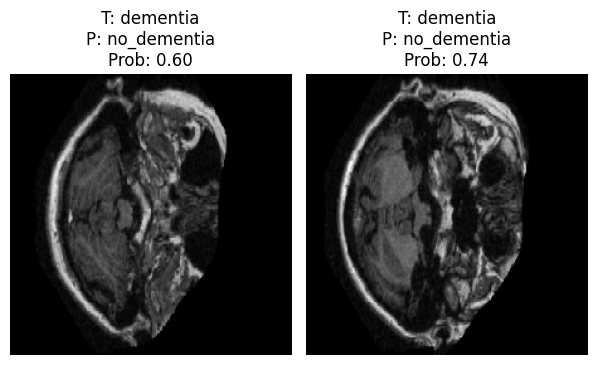

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Tomamos un batch del generador de test
test_gen.reset()
x_batch, y_batch = next(test_gen)

# Predicciones del modelo para ese batch
y_prob_batch = model.predict(x_batch).ravel()
y_pred_batch = (y_prob_batch >= 0.5).astype(int)

# Diccionario id -> nombre de clase
class_indices = test_gen.class_indices          # p.ej. {'no_dementia': 0, 'dementia': 1}
inv_class_indices = {v: k for k, v in class_indices.items()}

n_imgs = min(8, x_batch.shape[0])

plt.figure(figsize=(12, 8))
for i in range(n_imgs):
    plt.subplot(2, 4, i + 1)

    # Deshacer parcialmente el preprocess_input de VGG16 para visualizar
    img = x_batch[i].copy()
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 123.68
    img = np.clip(img / 255.0, 0, 1)

    plt.imshow(img)

    true_id = int(y_batch[i])
    pred_id = int(y_pred_batch[i])

    true_label = inv_class_indices.get(true_id, f"clase {true_id}")
    pred_label = inv_class_indices.get(pred_id, f"clase {pred_id}")

    plt.title(f"T: {true_label}\nP: {pred_label}\nProb: {y_prob_batch[i]:.2f}")
    plt.axis("off")

plt.tight_layout()
plt.show()


3748/3748 ━━━━━━━━━━━━━━━━━━━━ 3932s 1s/step
Tamaño de y_true: 7496
Tamaño de y_pred: 7496

F1-score: 0.7170
IoU: 0.5589
AUC (ROC): 0.6509


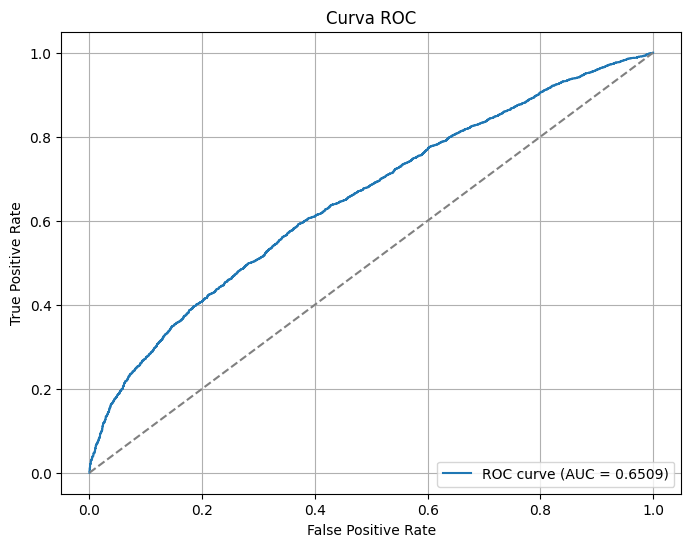

In [24]:
import numpy as np
from sklearn.metrics import (
    f1_score,
    roc_curve,
    roc_auc_score
)
import matplotlib.pyplot as plt

# 1. Obtener las predicciones completas del test (rápido)

test_gen.reset()
y_true = test_gen.classes
y_prob = model.predict(test_gen, steps=len(test_gen)).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print("Tamaño de y_true:", len(y_true))
print("Tamaño de y_pred:", len(y_pred))

# 2. F1-score

f1 = f1_score(y_true, y_pred)
print(f"\nF1-score: {f1:.4f}")

# 3. IoU (Intersection over Union)
#    Para clasificación binaria: IoU = TP / (TP + FP + FN)

TP = np.sum((y_true == 1) & (y_pred == 1))
FP = np.sum((y_true == 0) & (y_pred == 1))
FN = np.sum((y_true == 1) & (y_pred == 0))

IoU = TP / (TP + FP + FN + 1e-7)
print(f"IoU: {IoU:.4f}")

# 4. Curva ROC y AUC

fpr, tpr, thresholds = roc_curve(y_true, y_prob)
auc_value = roc_auc_score(y_true, y_prob)

print(f"AUC (ROC): {auc_value:.4f}")

# 5. Gráfica ROC

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_value:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
